<a href="https://colab.research.google.com/github/Aakriti555/Nammi-task3/blob/main/NAAMII_Task_3_Bone_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [215]:
!pip install nibabel

In [216]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib # common way of importing nibabel
from skimage.feature import peak_local_max
from collections import deque

In [217]:
import gdown
gdown.download(url="https://drive.google.com/file/d/1NR7OEboARP_fpseIZOY0Wy8Ir1NEYfL5/edit", output="3702_left_knee.nii.gz", fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1NR7OEboARP_fpseIZOY0Wy8Ir1NEYfL5
From (redirected): https://drive.google.com/uc?id=1NR7OEboARP_fpseIZOY0Wy8Ir1NEYfL5&confirm=t&uuid=130b5082-70db-4ced-9ad3-94c627513c96
To: /content/3702_left_knee.nii.gz
100%|██████████| 26.2M/26.2M [00:00<00:00, 242MB/s]


'3702_left_knee.nii.gz'

In [218]:
mri_file = '/content/3702_left_knee.nii.gz'
img = nib.load(mri_file)
print(type(img))

<class 'nibabel.nifti1.Nifti1Image'>


In [219]:
print(img.shape)

(512, 512, 216)


In [220]:
# here, we're storing the header attribute in a new variable, hdr, for easy of use
hdr = img.header

In [221]:
hdr.get_zooms()  # it's a 1x1x1 mm MRI file!

(np.float32(0.869141), np.float32(0.869141), np.float32(2.0))

In [222]:
img_data = img.get_fdata()

In [223]:
slice_index = 260  # adjust as needed
mid_slice_x = img_data[:,slice_index, :]
print(mid_slice_x.shape)

(512, 216)


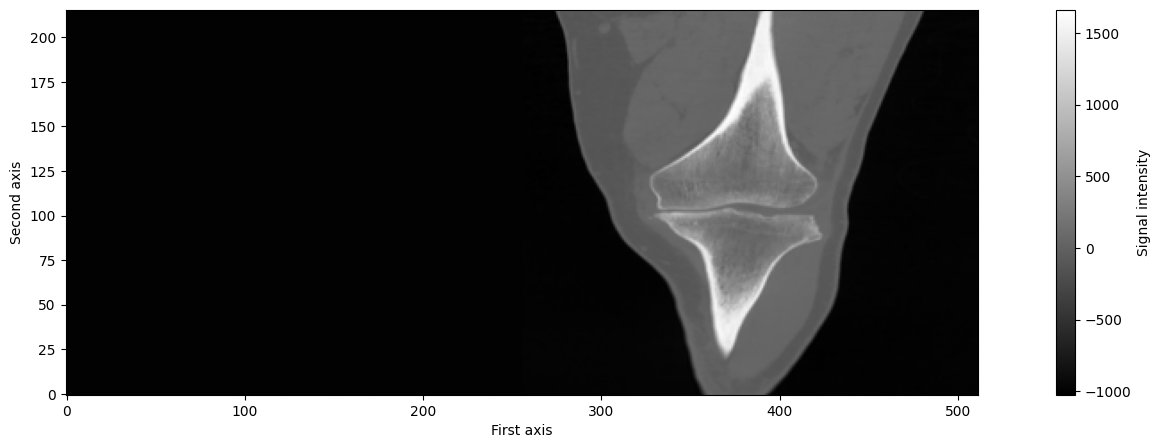

In [224]:
# Note that the transpose the slice (using the .T attribute).
# This is because imshow plots the first dimension on the y-axis and the
# second on the x-axis, but we'd like to plot the first on the x-axis and the
# second on the y-axis. Also, the origin to "lower", as the data was saved in
# "cartesian" coordinates.
plt.imshow(mid_slice_x.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

## Segmentation

In [225]:
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

import ipywidgets as widgets
from IPython.display import display
import cv2

In [226]:
# Get the data as a NumPy array

img = img.get_fdata()

In [227]:
img = img.transpose(1, 0, 2)
img = np.rot90(img, k=3, axes=(1, 2))

In [228]:
# Function to update the plot
def update_ct_display_slice(slice_index):
    plt.figure()
    plt.xlabel('First axis')
    plt.ylabel('Second axis')
    plt.pcolormesh(img[slice_index])
    plt.colorbar()
    plt.show()

# Create a slider
slider = widgets.IntSlider(value=0, min=200, max=320, step=1, description='Slice:')
widgets.interact(update_ct_display_slice, slice_index=slider)

interactive(children=(IntSlider(value=200, description='Slice:', max=320, min=200), Output()), _dom_classes=('…

<function __main__.update_ct_display_slice(slice_index)>

# Separating Bone from Background

In [229]:
threshold = 120

# Set all values below threshold to 0
img_bones = np.where(img >= threshold, img, 0)
img_background = np.where(img < threshold, img, 0)

In [230]:
# Function to update the plot
def update_ct_display_slice(slice_index):

    plt.figure()
    plt.pcolormesh(img_bones[slice_index])
    plt.colorbar()
    plt.title(f"Bone Only Slice {slice_index}")
    plt.show()

# Create a slider
slider = widgets.IntSlider(value=260, min=200, max=320, step=1, description='Slice:')
widgets.interact(update_ct_display_slice, slice_index=slider)

interactive(children=(IntSlider(value=260, description='Slice:', max=320, min=200), Output()), _dom_classes=('…

<function __main__.update_ct_display_slice(slice_index)>

In [231]:
# Visualizing the Background

def update_ct_display_slice(slice_index):

    plt.figure()
    plt.pcolormesh(img_background[slice_index])
    plt.colorbar()
    plt.title(f"Bone Only Slice {slice_index}")
    plt.show()

# Create a slider
slider = widgets.IntSlider(value=0, min=200, max=320, step=1, description='Slice:')
widgets.interact(update_ct_display_slice, slice_index=slider)

interactive(children=(IntSlider(value=200, description='Slice:', max=320, min=200), Output()), _dom_classes=('…

<function __main__.update_ct_display_slice(slice_index)>

In [232]:
from scipy.ndimage import gaussian_filter, median_filter

# Edge enhancement with unsharp masking
blurred = gaussian_filter(img_bones, sigma=2)
img_edges = img_bones + (img_bones - blurred) * 2  # Adjust multiplier for edge strength

In [233]:
# Function to update the plot
def update_ct_display_slice(slice_index):

    plt.figure()
    plt.pcolormesh(img_edges[slice_index])
    plt.colorbar()
    plt.title(f"Edge Enhanced Slice {slice_index}")
    plt.show()

# Create a slider
slider = widgets.IntSlider(value=0, min=200, max=300, step=1, description='Slice:')
widgets.interact(update_ct_display_slice, slice_index=slider)

interactive(children=(IntSlider(value=200, description='Slice:', max=300, min=200), Output()), _dom_classes=('…

<function __main__.update_ct_display_slice(slice_index)>

In [234]:
mask = img_edges > 250
def update_segmentation_slice(slice_index):
    plt.figure()
    plt.pcolormesh(mask[slice_index])
    plt.colorbar()
    plt.title(f"Masked Slice {slice_index}")
    plt.show()

slider = widgets.IntSlider(value=0, min=200, max=300, step=1, description='Slice:')
widgets.interact(update_segmentation_slice, slice_index=slider)

interactive(children=(IntSlider(value=200, description='Slice:', max=300, min=200), Output()), _dom_classes=('…

<function __main__.update_segmentation_slice(slice_index)>

In [235]:
from skimage.morphology import remove_small_objects
from scipy.ndimage import binary_fill_holes

# Remove small connected components (3D-aware)
cleaned_mask = remove_small_objects(mask, min_size=2000, connectivity=1)

# First pass: fill holes in axial slices (XY planes)
filled_mask = np.zeros_like(cleaned_mask, dtype=bool)
for i in range(cleaned_mask.shape[0]):
    filled_mask[i] = binary_fill_holes(cleaned_mask[i])

# Second pass: fill holes in sagittal slices (YZ planes)
for j in range(filled_mask.shape[2]):
    filled_mask[:, :, j] = binary_fill_holes(filled_mask[:, :, j])

In [236]:
def update_segmentation_slice(slice_index):
    plt.figure()
    plt.pcolormesh(filled_mask[slice_index])
    plt.colorbar()
    plt.title(f"Partially Filled and Noise Free Slice {slice_index}")
    plt.show()

slider = widgets.IntSlider(value=0, min=200, max=300, step=1, description='Slice:')
widgets.interact(update_segmentation_slice, slice_index=slider)

interactive(children=(IntSlider(value=200, description='Slice:', max=300, min=200), Output()), _dom_classes=('…

<function __main__.update_segmentation_slice(slice_index)>

## Separate Femur from Tibia

In [237]:
# from scipy.ndimage import label, center_of_mass

# # filled_mask is a 2D boolean mask where both bones are connected regions

# # Label connected components
# labeled_mask, num_labels = label(filled_mask)

# # Compute vertical (y-axis) centroids
# centroids = center_of_mass(filled_mask, labeled_mask, range(1, num_labels + 1))
# centroids_y = [c[0] for c in centroids]  # y-coordinates (row)

# # Sort labels by vertical position (top = femur, bottom = tibia)
# sorted_labels = [label_idx for _, label_idx in sorted(zip(centroids_y, range(1, num_labels + 1)))]

# # Create masks
# femur_mask = (labeled_mask == sorted_labels[0]) | (labeled_mask == sorted_labels[1])
# tibia_mask = labeled_mask == sorted_labels[2]


In [238]:
# def update_segmentation_slice(slice_index):
#     fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#     im1 = axs[0].pcolormesh(tibia_mask[slice_index])
#     axs[0].set_title(f"Tibia Mask Slice {slice_index}")
#     plt.colorbar(im1, ax=axs[0])

#     im2 = axs[1].pcolormesh(femur_mask[slice_index])
#     axs[1].set_title(f"Femur Mask Slice {slice_index}")
#     plt.colorbar(im2, ax=axs[1])

#     plt.show()

# slider = widgets.IntSlider(value=0, min=200, max=300, step=1, description='Slice:')
# widgets.interact(update_segmentation_slice, slice_index=slider)

## Filling the internal gaps

In [239]:
# def apply_mask_coloring(mask_bool, kernel_size=15, iterations=2):
#     # Convert boolean mask to uint8 for cv2 operations (0 and 255)
#     mask_uint8 = mask_bool.astype(np.uint8) * 255

#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
#     closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel, iterations=iterations)

#     # Convert back to boolean for filling holes
#     closed_bool = closed.astype(bool)

#     # Fill holes on the boolean mask
#     filled = binary_fill_holes(closed_bool)

#     return filled

# # Apply separately
# femur_mask_filled = apply_mask_coloring(femur_mask)
# tibia_mask_filled = apply_mask_coloring(tibia_mask)

In [240]:
# def update_segmentation_slice(slice_index):
#     fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#     im1 = axs[0].pcolormesh(tibia_mask_filled[slice_index])
#     axs[0].set_title(f"Tibia Filled Slice {slice_index}")
#     plt.colorbar(im1, ax=axs[0])

#     im2 = axs[1].pcolormesh(femur_mask_filled[slice_index])
#     axs[1].set_title(f"Femur Filled Slice {slice_index}")
#     plt.colorbar(im2, ax=axs[1])

#     plt.show()

# slider = widgets.IntSlider(value=0, min=200, max=300, step=1, description='Slice:')
# widgets.interact(update_segmentation_slice, slice_index=slider)

In [241]:
# femur_segment = img * femur_mask_filled
# tibia_segment = img * tibia_mask_filled
# overall_mask = femur_mask_filled | tibia_mask_filled
# overall_segment = img * overall_mask

In [242]:
# def update_segmentation_slice(slice_index):
#     fig, axs = plt.subplots(1, 3, figsize=(18, 5))

#     im1 = axs[0].pcolormesh(femur_segment[slice_index])
#     axs[0].set_title(f"Femur Segment Slice {slice_index}")
#     plt.colorbar(im1, ax=axs[0])

#     im2 = axs[1].pcolormesh(tibia_segment[slice_index])
#     axs[1].set_title(f"Tibia Segment Slice {slice_index}")
#     plt.colorbar(im2, ax=axs[1])

#     im3 = axs[2].pcolormesh(overall_segment[slice_index])
#     axs[2].set_title(f"Overall Segment Slice {slice_index}")
#     plt.colorbar(im3, ax=axs[2])

#     plt.tight_layout()
#     plt.show()

# slider = widgets.IntSlider(value=0, min=200, max=300, step=1, description='Slice:')
# widgets.interact(update_segmentation_slice, slice_index=slider)


In [243]:
# start_slice = 200
# end_slice = 300

# # Cropped femur and tibia segments
# femur_segment_cropped = femur_segment[start_slice:end_slice]
# tibia_segment_cropped = tibia_segment[start_slice:end_slice]


In [244]:
# # Optional visualization
# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.imshow(femur_mask[:, 255, :].T, cmap='gray', origin='lower')
# plt.title('Femur Mask')

# plt.subplot(1, 2, 2)
# plt.imshow(tibia_mask[:, 267, :].T, cmap='gray', origin='lower')
# plt.title('Tibia Mask')
# plt.show()

# 2. Conversion of 2D Pretrained Model to 3D

In [245]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# import torch.nn.functional as F
# import torchvision.models as models
# from collections import OrderedDict
# import copy

In [246]:
# def inflate_conv_layer_2d_to_3d(conv2d, depth=3):
#     """
#     Inflate a Conv2d to Conv3d by repeating the weights along a new depth
#     dimension and padding so that D is preserved.
#     """
#     w2d = conv2d.weight.data
#     w3d = w2d.unsqueeze(2).repeat(1, 1, depth, 1, 1) / depth

#     pad_d = depth // 2

#     conv3d = nn.Conv3d(
#         in_channels=conv2d.in_channels,
#         out_channels=conv2d.out_channels,
#         kernel_size=(depth, *conv2d.kernel_size),
#         stride=(1, *conv2d.stride),
#         padding=(pad_d, *conv2d.padding),
#         bias=(conv2d.bias is not None)
#     )
#     conv3d.weight.data = w3d
#     if conv2d.bias is not None:
#         conv3d.bias.data = conv2d.bias.data.clone()
#     return conv3d


# def pad_to_match(x, target):
#     """Pad tensor `x` to match the spatial shape of `target`."""
#     diff = [t - s for s, t in zip(x.shape[2:], target.shape[2:])]
#     pad = [p for d in reversed(diff) for p in (0, d)]  # [W, H, D]
#     return F.pad(x, pad)



# def convert_densenet2d_to_3d(model2d, depth=3):
#     model3d = copy.deepcopy(model2d)

#     def recursively_convert(module):
#         for name, child in list(module.named_children()):
#             if isinstance(child, nn.Conv2d):
#                 setattr(module, name, inflate_conv_layer_2d_to_3d(child, depth))
#             elif isinstance(child, nn.BatchNorm2d):
#                 new_bn = nn.BatchNorm3d(child.num_features)
#                 new_bn.weight.data = child.weight.data.clone()
#                 new_bn.bias.data = child.bias.data.clone()
#                 new_bn.running_mean = child.running_mean.clone()
#                 new_bn.running_var = child.running_var.clone()
#                 setattr(module, name, new_bn)
#             elif isinstance(child, nn.AdaptiveAvgPool2d):
#                 setattr(module, name, nn.AdaptiveAvgPool3d((1, 1, 1)))
#             elif isinstance(child, nn.MaxPool2d):
#                 setattr(module, name, nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)))
#             elif isinstance(child, nn.AvgPool2d):
#                 setattr(module, name, nn.AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)))
#             else:
#                 recursively_convert(child)

#     recursively_convert(model3d.features)
#     return model3d

In [247]:
# model2d = models.densenet121(pretrained=True)
# model3d = convert_densenet2d_to_3d(model2d)
# model3d.eval()
# print("Done")

In [248]:
# def extract_gap_features_from_layer(model, volume_tensor):
#     with torch.no_grad():
#         x = model.features(volume_tensor)
#         print("feature map shape:", x.shape)      #torch.Size([1, 1024, D', H', W'])
#         pooled = F.adaptive_avg_pool3d(x, (1, 1, 1))
#         print("after pooling:", pooled.shape)
#         vector = pooled.view(pooled.size(0), -1).cpu().numpy()
#     return vector

In [249]:
# from collections import OrderedDict

# feat_maps = OrderedDict()

# conv_layers = []
# for name, module in model3d.features.named_modules():
#     if isinstance(module, torch.nn.Conv3d):
#         conv_layers.append(name)

# # Pick indices: last (-1), third-last (-3), fifth-last (-5)
# targets = {
#     'last':   conv_layers[-1],
#     'third':  conv_layers[-3],
#     'fifth':  conv_layers[-5],
# }

# # Register hooks
# for key, layer_name in targets.items():
#     module = dict(model3d.features.named_modules())[layer_name]
#     module.register_forward_hook(
#         lambda self, input, output, k=key: feat_maps.__setitem__(k, output)
#     )

In [250]:
# def preprocess_ct_volume(volume, hu_min=-1000, hu_max=1000):
#     clipped = np.clip(volume, hu_min, hu_max)
#     normed = (clipped - hu_min) / (hu_max - hu_min)
#     tensor = torch.tensor(normed[None, None], dtype=torch.float32)  # (1,1,D,H,W)
#     # Reduce the input dimensions
#     tensor = F.interpolate(tensor, size=(256, 128, 256), mode='trilinear', align_corners=False)
#     tensor = tensor.repeat(1, 3, 1, 1, 1)  # (1,3,D,H,W)

#     # _, _, d, h, w = tensor.shape
#     # pad_d = (32 - d % 32) % 32
#     # pad_h = (32 - h % 32) % 32
#     # pad_w = (32 - w % 32) % 32

#     # padding = (0, pad_w, 0, pad_h, 0, pad_d)
#     # tensor = F.pad(tensor, padding)

#     return tensor



# tibia_tensor = preprocess_ct_volume(tibia_segment_cropped)
# femur_tensor = preprocess_ct_volume(femur_segment_cropped)
# background_tensor = preprocess_ct_volume(img_background)

In [251]:
# from torch.nn import CosineSimilarity
# import torch.nn.functional as F

# cos = CosineSimilarity(dim=1, eps=1e-6)

# def extract_features_per_region(volume_tensor):
#     """
#     volume_tensor: torch.Tensor shape (1,3,D,H,W) on CPU
#     returns dict: {'last': torch.Tensor, 'third': torch.Tensor, 'fifth': torch.Tensor}
#     """
#     feat_maps.clear()
#     with torch.no_grad():
#         _ = model3d.features(volume_tensor)   # forward through features

#     vectors = {}
#     for key, fmap in feat_maps.items():
#         # Global average pooling to (1, C, 1, 1, 1)
#         pooled = F.adaptive_avg_pool3d(fmap, (1,1,1))
#         vec = pooled.view(pooled.size(0), -1)  # (1, C)
#         vectors[key] = vec
#     return vectors

In [252]:
# regions = {
#     'tibia': tibia_tensor,
#     'femur': femur_tensor,
#     'background': background_tensor
# }

# rows = []
# pairs = [('tibia','femur'), ('tibia','background'), ('femur','background')]

# layers = ['last','third','fifth']

# # Precompute features per region
# region_feats = {r: extract_features_per_region(t) for r, t in regions.items()}

# for img_idx in [0]:
#     for (r1, r2) in pairs:
#         feats1 = region_feats[r1]
#         feats2 = region_feats[r2]
#         row = {
#             'image': img_idx,
#             'pair': f"{r1}_{r2}"
#         }
#         for layer in layers:
#             sim = cos(feats1[layer], feats2[layer]).item()
#             row[f"cos_{layer}"] = sim
#         rows.append(row)

# df = pd.DataFrame(rows)
# csv_path = "knee_region_cosine_similarities.csv"
# df.to_csv(csv_path, index=False)
# print(f"Saved similarities to {csv_path}")


In [253]:
# df

In [254]:
!pip install opencv-python